In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
import scipy.io
import scipy.sparse as sp

from math import sqrt

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1, '../utilities/')
from helpers import *
from plots import *

# Load of training data

The ID indicates both the user and the item : user are identified as "r"+"index" from 1 to 10000, and items as "c"+ "index" from 1 to 1000. The format of the ID are consequently : r index(user) _ c index(item).
The ratings are given as integers from 1 to 5.

We compute them into a matrix with items as row and users as columns. All of the missing ratings are set as 0 and should be predicted to have a valid rating format.

In [3]:
DATA_TRAIN_PATH = '../Datasets/data_train.csv'
ratings = load_data(DATA_TRAIN_PATH)

number of items: 1000, number of users: 10000


In [4]:
ratings.shape

(1000, 10000)

# Data analysis

### Plot the number of ratings per movie and user

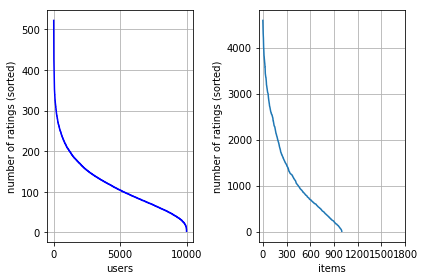

min # of items per user = 3, min # of users per item = 8.


In [5]:
num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Data preprocessing - Split the data into a train and test set

In [6]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    # split the data and return train and test data.
    # we only consider users and movies that have more than 10 ratings

    ind_test = np.random.choice(valid_ratings.nnz, int(valid_ratings.nnz*p_test), replace=False)
    ind_train = np.delete(np.arange(valid_ratings.nnz),ind_test)
    
    valid_ratings_coo = valid_ratings.tocoo()
    data = valid_ratings_coo.data
    row = valid_ratings_coo.row
    col = valid_ratings_coo.col
    
    test = sp.coo_matrix((data[ind_test], (row[ind_test], col[ind_test])), shape=valid_ratings.get_shape())
    train = sp.coo_matrix((data[ind_train], (row[ind_train], col[ind_train])), shape=valid_ratings.get_shape()) 
    
    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1059186
Total number of nonzero elements in test data:117687


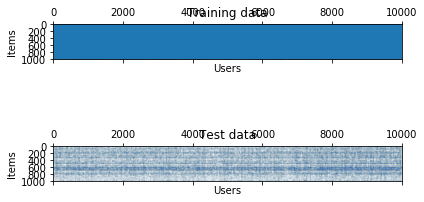

In [7]:
valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
plot_train_test_data(train, test)

# Standard implementations

## Implementing Baselines 

### Use the global mean to do the prediction

In [11]:
def baseline_global_mean(train, test):
    """baseline method: use the global mean."""  
    
    return sqrt(calculate_mse(test.data,np.mean(train.data))/(test.nnz))

baseline_global_mean(train, test)

1.1167843007553209

### Use the user means as the prediction

In [9]:
def baseline_user_mean(train, test):
    """baseline method: use the user means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    #Sum over nth user
    sum_ratings_movie = np.squeeze(np.asarray(train.sum(0)))    # sum of the nonzero elements, for each row
    count_ratings_movie = np.diff(train.tocsc().indptr)         # count of the nonzero elements, for each row
    mean_rating_movie = sum_ratings_movie/count_ratings_movie
    return sqrt(calculate_mse(test.data,mean_rating_movie[test.col])/(test.nnz))

baseline_user_mean(train, test)

1.0943344686705307

In [12]:
def baseline_item_mean(train, test):
    """baseline method: use item means as the prediction."""
    mse = 0
    num_items, num_users = train.shape
    
    #Sum over dth movie
    sum_ratings_user = np.squeeze(np.asarray(train.sum(1)))    # sum of the nonzero elements, for each row
    count_ratings_user = np.diff(train.tocsr().indptr)         # count of the nonzero elements, for each row
    mean_rating_user = sum_ratings_user/count_ratings_user

    return sqrt(calculate_mse(test.data,mean_rating_user[test.row])/(test.nnz))
    
baseline_item_mean(train, test)

1.0292360165304137

### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [11]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    
    # returns initialized with random values :
    #     user_features: shape = num_features, num_user
    #     item_features: shape = num_features, num_item

    
    max_initial_value = 2*sqrt(np.mean(train.data)/num_features)
    
    user_features = max_initial_value*np.random.rand(num_features, train.shape[1])
    item_features = max_initial_value*np.random.rand(num_features, train.shape[0])

    
    return user_features,item_features

In [13]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""

    # calculate rmse (we only consider nonzero entries.)
    approx_data_matrix = np.dot(item_features.T,user_features)
    return sqrt(calculate_mse(data,approx_data_matrix[nz])/(len(data)))

#### Matrix factorization SGD basic

In [14]:
def matrix_factorization_SGD(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.05
    num_features = 25   # K in the lecture notes
    num_epochs = 30     # number of full iterations through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col, train.data))

    print("learn the matrix factorization using SGD...")
    rmse_tr = compute_error(train.data, user_features, item_features, train.nonzero())
    rmse_te = compute_error(test.data, user_features, item_features, test.nonzero())
    print("initial RMSE on training set: {}, RMSE on testing set: {}.".format(rmse_tr,rmse_te))
    
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        for d, n, x_dn in nz_train:
        # update matrix factorization.     

            item_features[:,d] += gamma*(x_dn - np.inner(item_features[:,d],user_features[:,n]))*user_features[:,n]
            user_features[:,n] += gamma*(x_dn - np.inner(item_features[:,d],user_features[:,n]))*item_features[:,d]
        
        rmse_tr = compute_error(train.data, user_features, item_features, train.nonzero())
        rmse_te = compute_error(test.data, user_features, item_features, test.nonzero())
        print("iter: {}, RMSE on training set: {}, RMSE on testing set: {}.".format(it, rmse_tr,rmse_te))
        
        errors.append(rmse_te)

    # evaluate the test error.
    rmse = compute_error(test.data, user_features, item_features, test.nonzero())
    print("RMSE on test data: {}.".format(rmse))

matrix_factorization_SGD(train, test)

learn the matrix factorization using SGD...
initial RMSE on training set: 0.9242795940692609, RMSE on testing set: 0.9229432551970851.
iter: 0, RMSE on training set: 0.7551226529794784, RMSE on testing set: 0.7798281206770704.
iter: 1, RMSE on training set: 0.7353196989201621, RMSE on testing set: 0.7774262340533424.
iter: 2, RMSE on training set: 0.7159951375296875, RMSE on testing set: 0.7772822204771538.
iter: 3, RMSE on training set: 0.6930454710950325, RMSE on testing set: 0.7705686972383131.
iter: 4, RMSE on training set: 0.6787744021172682, RMSE on testing set: 0.7704262844763868.
iter: 5, RMSE on training set: 0.6627107728688244, RMSE on testing set: 0.7683805807631051.
iter: 6, RMSE on training set: 0.6501771386324544, RMSE on testing set: 0.7668010646287436.
iter: 7, RMSE on training set: 0.6417126873973474, RMSE on testing set: 0.7668197427655713.
iter: 8, RMSE on training set: 0.6332466418921628, RMSE on testing set: 0.7644974419126828.
iter: 9, RMSE on training set: 0.6257

KeyboardInterrupt: 

#### Matrix factorization SGD regularized

In [19]:
def matrix_factorization_SGD_regularized(train, test):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.05
    num_features = 40   # K in the lecture notes
    lambda_user = 0.08
    lambda_item = 0.08
    num_epochs = 30     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    
    # find the non-zero ratings indices  
    nz_train = list(zip(train.row, train.col, train.data))

    print("learn the matrix factorization using SGD...")
    rmse_tr = compute_error(train.data, user_features, item_features, train.nonzero())
    rmse_te = compute_error(test.data, user_features, item_features, test.nonzero())
    print("initial RMSE on training set: {}, RMSE on testing set: {}.".format(rmse_tr,rmse_te))
    
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        for d, n, x_dn in nz_train:
        # update matrix factorization.

            item_features[:,d] += gamma*((x_dn - np.inner(item_features[:,d],user_features[:,n]))*user_features[:,n]-lambda_item*item_features[:,d])
            user_features[:,n] += gamma*((x_dn - np.inner(item_features[:,d],user_features[:,n]))*item_features[:,d]-lambda_user*user_features[:,n])
        
        rmse_tr = compute_error(train.data, user_features, item_features, train.nonzero())
        rmse_te = compute_error(test.data, user_features, item_features, test.nonzero())
        print("iter: {}, RMSE on training set: {}, RMSE on testing set: {}.".format(it, rmse_tr,rmse_te))
        
        errors.append(rmse_te)

    # evaluate the test error.

    rmse = compute_error(test.data, user_features, item_features, test.nonzero())
    print("RMSE on test data: {}.".format(rmse))

matrix_factorization_SGD_regularized(train, test)

learn the matrix factorization using SGD...
initial RMSE on training set: 0.8761487128562008, RMSE on testing set: 0.8748569697948582.
iter: 0, RMSE on training set: 0.7487018045183629, RMSE on testing set: 0.7618114427846111.
iter: 1, RMSE on training set: 0.7342666376516588, RMSE on testing set: 0.7498268694806172.
iter: 2, RMSE on training set: 0.7256888868343124, RMSE on testing set: 0.7418810389339027.
iter: 3, RMSE on training set: 0.7183119074025851, RMSE on testing set: 0.7384882146552089.
iter: 4, RMSE on training set: 0.7055575089839701, RMSE on testing set: 0.7284712288120987.
iter: 5, RMSE on training set: 0.6948238606406634, RMSE on testing set: 0.7214456896106597.
iter: 6, RMSE on training set: 0.6859438769148549, RMSE on testing set: 0.7157699245194948.
iter: 7, RMSE on training set: 0.6814758892050096, RMSE on testing set: 0.7136789273642431.
iter: 8, RMSE on training set: 0.6766146523516753, RMSE on testing set: 0.7108506307538576.
iter: 9, RMSE on training set: 0.6723

##### Tuning Hyperparameters

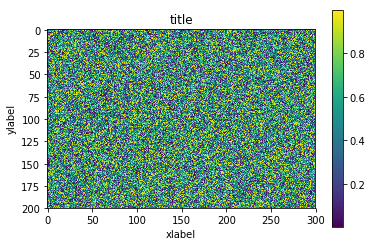

In [3]:
def plot_simple_heatmap(data, title, xlabel, ylabel):

    f,a = plt.subplots()
    a.set_xlabel(xlabel)
    a.set_ylabel(ylabel)
    a.set_title(title)
    heatmap_corr = a.imshow(data)
    f.colorbar(heatmap_corr, ax=a)
    
data = np.random.rand(200,300)
plot_simple_heatmap(data, "title", "xlabel", "ylabel")

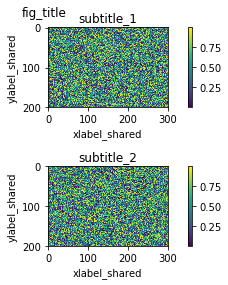

In [4]:
def plot_simple_heatmaps(data_1, data_2, fig_title, subtitle_1, subtitle_2, xlabel_shared, ylabel_shared):

    f,a = plt.subplots(2,1)
    
    a[0].set_xlabel(xlabel_shared)
    a[0].set_ylabel(ylabel_shared)
    a[0].set_title(subtitle_1)
    heatmap_0 = a[0].imshow(data_1)

    a[1].set_xlabel(xlabel_shared)
    a[1].set_ylabel(ylabel_shared)
    a[1].set_title(subtitle_2)
    heatmap_1 = a[1].imshow(data_2)

    plt.tight_layout()
    
    f.colorbar(heatmap_0,ax=a[0])
    f.colorbar(heatmap_1,ax=a[1])
    
    f.suptitle(fig_title)
    
data_1 = np.random.rand(200,300)
data_2 = np.random.rand(200,300)
plot_simple_heatmaps(data_1, data_2, 'fig_title', 'subtitle_1', 'subtitle_2', 'xlabel_shared', 'ylabel_shared')

### Learn the Matrix Factorization using Alternating Least Squares

In [29]:
def update_user_feature(
        train, item_features, lambda_user,
        nnz_items_per_user, nz_user_itemindices):
    """update user feature matrix."""
    """the best lambda is assumed to be nnz_items_per_user[user] * lambda_user"""

    # update and return user feature.
    user_features = np.zeros((item_features.shape[0],train.shape[1]))
    
    for n in range(train.shape[1]):
        
        item_features_n = np.zeros(item_features.shape)
        item_features_n[:,nz_user_itemindices[n]] = item_features[:,nz_user_itemindices[n]]
        user_features[:,n] = np.linalg.solve(np.dot(item_features_n,item_features.T)+lambda_user*nnz_items_per_user[n]*np.identity(user_features.shape[0]),np.dot(item_features,np.squeeze(np.asarray(train.getcol(n).todense()))))
    
    return user_features

def update_item_feature(
        train, user_features, lambda_item,
        nnz_users_per_item, nz_item_userindices):
    """update item feature matrix."""
    """the best lambda is assumed to be nnz_items_per_item[item] * lambda_item"""

    # update and return item feature.
    item_features = np.zeros((user_features.shape[0],train.shape[0]))
    
    for d in range(train.shape[0]):
        
        user_features_d = np.zeros(user_features.shape)
        user_features_d[:,nz_item_userindices[d]] = user_features[:,nz_item_userindices[d]]
        item_features[:,d] = np.linalg.solve(np.dot(user_features_d,user_features.T)+lambda_item*nnz_users_per_item[d]*np.identity(user_features.shape[0]),np.dot(user_features,np.squeeze(np.asarray(train.getrow(d).todense()))))
    
    return item_features

In [30]:
def ALS(train, test):
    """Alternating Least Squares (ALS) algorithm."""
    # define parameters
    num_features = 20   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    stop_criterion = 1e-4
    change = 1
    error_list = [[0, 0]]
    max_iter = 50
    
    # set seed
    np.random.seed(988)

    # init ALS
    user_features, item_features = init_MF(train, num_features)
    
    # start you ALS-WR algorithm. 
    
    nz_row, nz_col = train.nonzero()
    
    nz_user_itemindices = [nz_row[nz_col==n] for n in range(train.shape[1])]
    nnz_items_per_user = np.array([len(nz_user_itemindice) for nz_user_itemindice in nz_user_itemindices])
    nz_item_userindices = [nz_col[nz_row==d] for d in range(train.shape[0])]
    nnz_users_per_item = np.array([len(nz_item_userindice) for nz_item_userindice in nz_item_userindices])
    
    rmse_tr = compute_error(train.data, user_features, item_features, train.nonzero())
    rmse_te = compute_error(test.data, user_features, item_features, test.nonzero())
    print("initial: RMSE on training set: {}, RMSE on testing set: {}.".format(rmse_tr,rmse_te))
    error_list.append([rmse_tr,rmse_te])
    
    it = 0
    while (it < max_iter and not np.isclose(error_list[it][0],error_list[it+1][0],stop_criterion)):
        it += 1
        
        user_features = update_user_feature(train, item_features, lambda_user, nnz_items_per_user, nz_user_itemindices)
        item_features = update_item_feature(train, user_features, lambda_item, nnz_users_per_item, nz_item_userindices)
        
        rmse_tr = compute_error(train.data, user_features, item_features, train.nonzero())
        rmse_te = compute_error(test.data, user_features, item_features, test.nonzero())
        print("iter: {}, RMSE on training set: {}, RMSE on testing set: {}.".format(it, rmse_tr,rmse_te))
        
        error_list.append([rmse_tr,rmse_te])
    rmse = compute_error(test.data, user_features, item_features, test.nonzero())
    print("RMSE on test data: {}.".format(rmse))
       

ALS(train, test)

initial: RMSE on training set: 0.9584919051682759, RMSE on testing set: 0.9578933994505825.
iter: 1, RMSE on training set: 0.8301317713031212, RMSE on testing set: 0.841371924030644.
iter: 2, RMSE on training set: 0.7818030485284905, RMSE on testing set: 0.7887547781372019.
iter: 3, RMSE on training set: 0.759744894012031, RMSE on testing set: 0.7667241152857011.
iter: 4, RMSE on training set: 0.7476135506204266, RMSE on testing set: 0.7546836071606116.
iter: 5, RMSE on training set: 0.7403229420049096, RMSE on testing set: 0.7474527863891837.
iter: 6, RMSE on training set: 0.7356663970904086, RMSE on testing set: 0.7428349820573751.
iter: 7, RMSE on training set: 0.7325633680168286, RMSE on testing set: 0.7397577641420071.
iter: 8, RMSE on training set: 0.7304321804657727, RMSE on testing set: 0.7376442208942993.


KeyboardInterrupt: 

- test and train

- kmean. surely not the most efficient method
- matrix factorizations
- neural network

# Output

In [ ]:
OUTPUT_PATH = '../Datasets/sample_submission.csv'
pred_submission =
create_csv_submission(ids_test, pred_submission, OUTPUT_PATH)
raise NotImplementedError